In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from multitask.utils import download_runs_wandb
from multitask.visualization.plots import get_wandb_run_dfs
from multitask.utils import BenchmarkType
from multitask.etl.suzuki_data_utils import get_suzuki_dataset
from multitask.etl.cn_data_utils import get_cn_dataset
import wandb
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
from tqdm import tqdm
import warnings

In [3]:
api = wandb.Api()
wandb_entity = "ceb-sre"
wandb_project = "multitask"

## Meta-Analysis 

In [4]:
runs = download_runs_wandb(
    api=api,
    wandb_entity=wandb_entity,
    wandb_project=wandb_project,
    include_tags=["final", "lightning_cloud"],
    only_finished_runs=True,
    # extra_filters = {
    #     "config.model_name": "reizman_suzuki_case_1",
    #     "config.strategy": "STBO",
    # }
)

2022-11-14 14:44:24,901 - multitask.utils - INFO - Downloading runs from wandb


In [28]:
artifacts = runs[0].logged_artifacts()
# for artifact in artifacts:
#     if artifact.type == "optimization_result":
#         path = artifact.download()

In [29]:
list(artifacts[1].files())

[<File repeat_19.json (None) 11.6KiB>,
 <File repeat_19_model.pth (None) 5.9KiB>]

In [17]:
from pathlib import Path

path = Path(path)
list(Path(path).glob("repeat_*.json"))[0]

PosixPath('artifacts/stbo_reizman_suzuki:v172/repeat_19.json')

In [ ]:
configs = []
runs_dict = {}
for run in tqdm(runs):
    config = run.config
    config["run_id"] = run.id
    configs.append(config)
    runs_dict[run.id] = run

### Uncertainty calibration

In [21]:
calibration_iteration = 3
yield_iteration = 10
config_df = pd.DataFrame(configs)
config_groups = config_df.groupby(["output_path"])

config_df = config_df[config_groups.transform('size')>2]
config_groups = config_df.groupby(["output_path"])
config_groups.size()
plot_data = []
yld_best_exps = []
for output_path, config_group in tqdm(config_groups, position=0):
    run_ids = config_group["run_id"].values

    rank_coeffs = []
    yld_bests = []
    run = runs_dict[run_ids[0]]
    strategy = run.config["strategy"]
    if strategy == "STBO":
        continue
    artifact_name = run.config["wandb_main_dataset_artifact_name"]
    model_name = run.config["model_name"]
    benchmark_type = run.config["benchmark_type"]
    artifact_path = api.artifact(
        f"{wandb_entity}/{wandb_project}/{artifact_name}"
    ).download()
    artifact_path = Path(artifact_path)
    if benchmark_type == "BenchmarkType.suzuki":
        main_ds = get_suzuki_dataset(
            data_path=artifact_path / f"{model_name}.pb",
            split_catalyst=True,
            print_warnings=False,
        )
    elif benchmark_type == "BenchmarkType.cn":
        main_ds = get_cn_dataset(
            data_path=artifact_path / f"{model_name}.pb",
            print_warnings=False,
        )
    yld_best_exp = main_ds["yld"].max()
    yld_best_exps.append(yld_best_exp)
    for run_id in run_ids[:20]:
        run = runs_dict[run_id]
        df = run.history(
            x_axis="iteration",
            keys=[
                "spearmans_rank_coefficient_uncertainty_residual",
                # "marginal_likelihood"
            ]
        )
        df = df.set_index("iteration", drop=True)
        rank_coeff = df.loc[calibration_iteration, "spearmans_rank_coefficient_uncertainty_residual"] 
        rank_coeffs.append(rank_coeff)

        df_yld = run.history(
            x_axis="iteration", keys=["yld_best"]
        )
        df_yld = df_yld.set_index("iteration", drop=True)
        yld_best = df_yld.loc[yield_iteration,"yld_best"]
        yld_bests.append(yld_best)
    plot_data.append([rank_coeffs, yld_bests])

  0%|          | 0/49 [00:00<?, ?it/s]/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-k0YbXS9f-py3.9/lib/python3.9/site-packages/tqdm/std.py:1195: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:
100%|██████████| 49/49 [09:48<00:00, 12.01s/it]


In [22]:
plot_data_means = []
plot_rank_coeff_stds = []
plot_best_yld_stds = []
for yld_best_exp, run_plot_data in zip(yld_best_exps, plot_data):
    mean_rank_coeff = np.mean(run_plot_data[0]) 
    std_rank_coeff = np.std(run_plot_data[0])
    plot_rank_coeff_stds.append(std_rank_coeff)
    mean_best_yld = np.mean(run_plot_data[1]) / yld_best_exp
    std_best_yld = np.std(np.array(run_plot_data[1])/yld_best_exp)
    plot_best_yld_stds.append(std_best_yld)
    plot_data_means.append([mean_rank_coeff,mean_best_yld])
plot_data_means = np.array(plot_data_means)

In [23]:
def flatten(l):
    lfinal = []
    for li in l:
        lfinal.extend(li)
    return lfinal

In [31]:
all_task_covars = [run_plot_data[0] for run_plot_data in plot_data]
all_task_covars = flatten(all_task_covars)
all_best_ylds = []
for best_yld_exp, run_plot_data in zip(yld_best_exps, plot_data):
    all_best_ylds += (np.array(run_plot_data[1])/best_yld_exp).tolist()

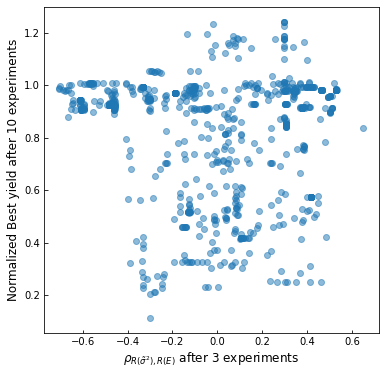

In [37]:
fig, ax = plt.subplots(1, figsize=(6,6))
ax.scatter(
    all_task_covars, 
    all_best_ylds ,
    # fmt="o",
    # markersize=10,
    # capsize=10,
    alpha=0.5
)
ax.tick_params(direction="in")
axis_fontsize=12
ax.set_xlabel(r"$\rho_{R(\tilde \sigma^2), R(E)}$" + f" after {calibration_iteration} experiments", fontsize=axis_fontsize)
ax.set_ylabel(f"Normalized Best yield after {yield_iteration} experiments", fontsize=axis_fontsize)
fig.savefig("../figures/uncertainty_correlation_scatter.png",dpi=300)

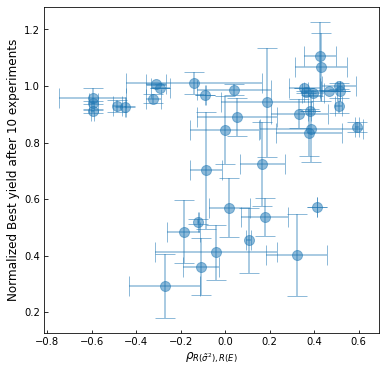

In [91]:
fig, ax = plt.subplots(1, figsize=(6,6))
ax.errorbar(
    plot_data_means[:,0], 
    plot_data_means[:,1],
    xerr=plot_rank_coeff_stds,
    yerr=plot_best_yld_stds,
    fmt="o",
    markersize=10,
    capsize=10,
    alpha=0.5
)
ax.tick_params(direction="in")
axis_fontsize=12
ax.set_xlabel(r"$\rho_{R(\tilde \sigma^2), R(E)}$", fontsize=axis_fontsize)
ax.set_ylabel("Normalized Best yield after 10 experiments", fontsize=axis_fontsize)
fig.savefig("../figures/uncertainty_correlation.png",dpi=300)

Not a strong correlation between uncertainty and optimization outcomes

### Task Correlation v1

In [46]:
iteration = 19
config_df = pd.DataFrame(configs)
config_groups = config_df.groupby(["output_path"])

config_df = config_df[config_groups.transform('size')>2]
config_groups = config_df.groupby(["output_path"])
config_groups.size()
plot_data = []
yld_best_exps = []
for output_path, config_group in tqdm(config_groups, position=0):
    run_ids = config_group["run_id"].values

    task_covars = []
    yld_bests = []
    run = runs_dict[run_ids[0]]
    strategy = run.config["strategy"]
    if strategy == "STBO":
        continue
    ct_dataset_names = run.config["ct_dataset_names"]
    if len(ct_dataset_names)>1:
        continue
    artifact_name = run.config["wandb_main_dataset_artifact_name"]
    model_name = run.config["model_name"]
    benchmark_type = run.config["benchmark_type"]
    artifact_path = api.artifact(
        f"{wandb_entity}/{wandb_project}/{artifact_name}"
    ).download()
    artifact_path = Path(artifact_path)
    if benchmark_type == "BenchmarkType.suzuki":
        main_ds = get_suzuki_dataset(
            data_path=artifact_path / f"{model_name}.pb",
            split_catalyst=True,
            print_warnings=False,
        )
    elif benchmark_type == "BenchmarkType.cn":
        main_ds = get_cn_dataset(
            data_path=artifact_path / f"{model_name}.pb",
            print_warnings=False,
        )
    yld_best_exp = main_ds["yld"].max()
    yld_best_exps.append(yld_best_exp)
    for run_id in run_ids[:20]:
        run = runs_dict[run_id]
        df = run.history(
            x_axis="iteration",
            keys=[
                "kernel/task_covar_0_1",
                # "marginal_likelihood"
            ]
        )
        df = df.set_index("iteration", drop=True)
        task_covar = df.loc[iteration, "kernel/task_covar_0_1"] 
        task_covars.append(task_covar)

        df_yld = run.history(
            x_axis="iteration", keys=["yld_best"]
        )
        df_yld = df_yld.set_index("iteration", drop=True)
        yld_best = df_yld.loc[iteration,"yld_best"]
        yld_bests.append(yld_best)
    plot_data.append([task_covars, yld_bests])

  0%|          | 0/49 [00:00<?, ?it/s]/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-k0YbXS9f-py3.9/lib/python3.9/site-packages/tqdm/std.py:1195: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:
100%|██████████| 49/49 [08:00<00:00,  9.81s/it]


In [54]:
all_rank_coeffs = [run_plot_data[0] for run_plot_data in plot_data]
all_rank_coeffs = flatten(all_rank_coeffs)
all_best_ylds = []
for best_yld_exp, run_plot_data in zip(yld_best_exps, plot_data):
    # all_best_ylds += (np.array(run_plot_data[1])/best_yld_exp).tolist()
    all_best_ylds += run_plot_data[1]

Text(0, 0.5, 'Normalized best yield after 20 experiments')

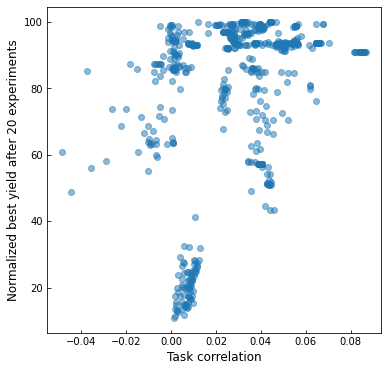

In [55]:
fig, ax = plt.subplots(1, figsize=(6,6))
ax.scatter(
    all_rank_coeffs, 
    all_best_ylds,
    # fmt="o",
    # markersize=10,
    # capsize=10,
    alpha=0.5
)
ax.tick_params(direction="in")
axis_fontsize=12
ax.set_xlabel(r"Task correlation", fontsize=axis_fontsize)
ax.set_ylabel(f"Normalized best yield after {iteration+1} experiments", fontsize=axis_fontsize)
# fig.savefig(f"../figures/task_correlation_scatter_iteration_{iteration+1}.png",dpi=300)

This plot doesn't actually make a lot of sense. I would hope there isn't a strong correlation between task covariance and best yield - hopefully the algorithm does fine even without the auxiliary task. What would be more useful to see is how well the task covariance is learned from a small subset of the data.

### Continuous variables

In [60]:
def get_df(artifact_path, model_name, benchmark_type):
    artifact_path = Path(artifact_path)
    if benchmark_type == "BenchmarkType.suzuki":
        main_ds = get_suzuki_dataset(
            data_path=artifact_path / f"{model_name}.pb",
            split_catalyst=True,
            print_warnings=False,
        )
    elif benchmark_type == "BenchmarkType.cn":
        main_ds = get_cn_dataset(
            data_path=artifact_path / f"{model_name}.pb",
            print_warnings=False,
        )
    return main_ds

- Download logged artifacts for the run 
- Sum the counts of each categorical variable
- Add to a total running count for a particular configuration